<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/17-representation-learning-and-generative-learning-using-autoencoders-and-gans/4_dimensionality_reduction_using_convolutional_and_recurrent_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality reduction using Convolutional & Recurrent Autoencoders

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction, especially for visualization purposes. 

Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks. Lastly, some autoencoders are generative models: they are capable of randomly generating new data that looks very similar to the training data.

For example, you could train an autoencoder on pictures of faces, and it would then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic.

In contrast, faces generated by generative adversarial networks (GANs) are now so convincing that it is hard to believe that the people they represent do not exist. You can judge so for yourself by visiting https://thispersondoesnotexist.com/, a website that shows faces generated by a recent GAN architecture called StyleGAN (you can also check out https://thisrentaldoesnotexist.com/ to see some generated Airbnb bedrooms).

GANs are now widely used for super resolution (increasing the resolution of
an image), colorization, powerful image editing (e.g., replacing photo bombers with realistic background), turning a simple sketch into a photorealistic image, predicting the next frames in a video, augmenting a dataset (to train other models), generating other types of data (such as text, audio, and time series), identifying the weaknesses in other models and strengthening them, and more.

Autoencoders and GANs are both unsupervised, they both learn dense representations, they can both be used as generative models, and they have many similar applications.

However, they work very differently:

* Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult. For example, you can limit the size of the latent representations, or you can add noise to the inputs and train the network to recover the original inputs. These constraints prevent the autoencoder from trivially copying the inputs directly to the outputs, which forces it to learn efficient ways of representing the data. In short, the codings are byproducts of the autoencoder learning the identity function under some constraints.

* GANs are composed of two neural networks: a generator that tries to generate data that looks similar to the training data, and a discriminator that tries to tell real data from fake data. This architecture is very original in Deep Learning in that the generator and the discriminator compete against each other during training: the generator is often compared to a criminal trying to make realistic counterfeit money, while the discriminator is like the police investigator trying to tell real money from fake.

We will start by exploring in more depth how autoencoders work and how to use them for dimensionality reduction, feature extraction, unsupervised pretraining, or as generative models. This will naturally lead us to GANs. We will start by building a simple GAN to generate fake images, but we will see that training is often quite difficult.



## Use-case

If you are dealing with images, then the autoencoders we have seen so far will not work well (unless the images are very small): convolutional
neural networks are far better suited than dense networks to work with images. 

So if you want to build an autoencoder for images (e.g., for unsupervised pretraining or dimensionality reduction), you will need to build a [convolutional autoencoder](http://people.idsia.ch/~ciresan/data/icann2011.pdf).


## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow 2.x selected.


A couple utility functions to plot grayscale 28x28 image:

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## Convolutional Autoencoders

The encoder is a regular CNN composed of convolutional layers and pooling layers. It typically reduces the spatial dimensionality of the inputs (i.e., height and width) while increasing the depth (i.e., the number of feature maps). 

The decoder must do the reverse (upscale the image and reduce its depth back to the original dimensions), and for this you can use transpose convolutional layers (alternatively, you could combine upsampling layers with convolutional layers). 

Let's load MNIST dataset.

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


Here is a simple convolutional autoencoder for Fashion MNIST:

In [0]:
def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [5]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# split the autoencoder model into two submodels: the encoder and the decoder.
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),    # encoder takes 28 × 28–pixel grayscale images, flattens them to vector of size 784
    keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),    
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),    
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),    
    keras.layers.MaxPooling2D(pool_size=2),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='selu', padding='valid', input_shape=[3, 3, 64]),  
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='selu', padding='same'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, activation='sigmoid', padding='same'),
    keras.layers.Reshape([28, 28])
])

conv_autoencoder = keras.models.Sequential([conv_encoder, conv_decoder])
conv_autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

# Finally, we train the model using X_train as both the inputs and the targets
# and similarly, we use X_valid as both the validation inputs and targets
history = conv_autoencoder.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 16s 284us/sample - loss: 0.3018 - rounded_accuracy: 0.9183 - val_loss: 0.2799 - val_rounded_accuracy: 0.9389
Epoch 2/10
55000/55000 [==============================] - 8s 138us/sample - loss: 0.2755 - rounded_accuracy: 0.9413 - val_loss: 0.2767 - val_rounded_accuracy: 0.9430
Epoch 3/10
55000/55000 [==============================] - 8s 143us/sample - loss: 0.2707 - rounded_accuracy: 0.9462 - val_loss: 0.2730 - val_rounded_accuracy: 0.9447
Epoch 4/10
55000/55000 [==============================] - 8s 139us/sample - loss: 0.2681 - rounded_accuracy: 0.9490 - val_loss: 0.2677 - val_rounded_accuracy: 0.9513
Epoch 5/10
55000/55000 [==============================] - 8s 140us/sample - loss: 0.2663 - rounded_accuracy: 0.9509 - val_loss: 0.2666 - val_rounded_accuracy: 0.9523
Epoch 6/10
55000/55000 [==============================] - 8s 140us/sample - loss: 0.2650 - rounded_accuracy: 0.9524 - va

In [6]:
conv_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0

In [7]:
conv_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________


## Visualizing the Reconstructions

One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs: the differences should not be too significant. 

Let’s plot a few images from the validation set, as well as their reconstructions:

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
  reconstructions = model.predict(images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

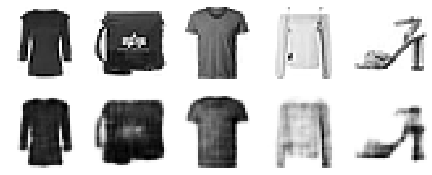

In [10]:
show_reconstructions(conv_autoencoder)

This model achieves a very slightly lower reconstruction error than the previous model, with almost half the number of parameters.

## Recurrent Autoencoders

If you want to build an autoencoder for sequences, such as time series or text (e.g., for unsupervised learning or dimensionality reduction), then recurrent neural networks may be better suited than dense networks.

Building a recurrent autoencoder is straightforward: the encoder is typically a sequence-to-vector RNN which compresses the input sequence down to a single vector. The decoder is a vector-to-sequence RNN that does the reverse:

* This recurrent autoencoder can process sequences of any length, with 28 dimensions per time step. Conveniently, this means it can process Fashion MNIST images by treating each image as a sequence of rows: at each time step, the RNN will process a single row of 28 pixels. Obviously, you could use a recurrent autoencoder for any kind of sequence.

* Note that we use a RepeatVector layer as the first layer of the
decoder, to ensure that its input vector gets fed to the decoder at each time step.



In [12]:
# split the autoencoder model into two submodels: the encoder and the decoder.
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),  
    keras.layers.LSTM(30),
])

recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),  
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid')),
])

recurrent_autoencoder = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_autoencoder.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])

# Finally, we train the model using X_train as both the inputs and the targets
# and similarly, we use X_valid as both the validation inputs and targets
history = recurrent_autoencoder.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 20s 368us/sample - loss: 0.5117 - rounded_accuracy: 0.7515 - val_loss: 0.4452 - val_rounded_accuracy: 0.8241
Epoch 2/10
55000/55000 [==============================] - 17s 304us/sample - loss: 0.4034 - rounded_accuracy: 0.8407 - val_loss: 0.3816 - val_rounded_accuracy: 0.8565
Epoch 3/10
55000/55000 [==============================] - 17s 305us/sample - loss: 0.3674 - rounded_accuracy: 0.8677 - val_loss: 0.3755 - val_rounded_accuracy: 0.8637
Epoch 4/10
55000/55000 [==============================] - 17s 305us/sample - loss: 0.3561 - rounded_accuracy: 0.8764 - val_loss: 0.3538 - val_rounded_accuracy: 0.8811
Epoch 5/10
55000/55000 [==============================] - 17s 307us/sample - loss: 0.3478 - rounded_accuracy: 0.8830 - val_loss: 0.3442 - val_rounded_accuracy: 0.8859
Epoch 6/10
55000/55000 [==============================] - 17s 308us/sample - loss: 0.3399 - rounded_accuracy: 0.8879

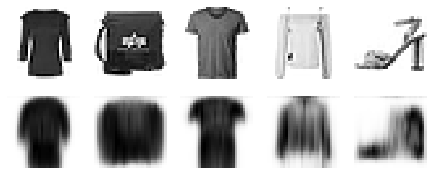

In [13]:
show_reconstructions(recurrent_autoencoder)

OK, let’s step back for a second. So far we have seen various kinds of autoencoders (basic, stacked, convolutional, and recurrent), and we have looked at how to train them (either in one shot or layer by layer). We also looked at a couple applications: data visualization and unsupervised pretraining.

Up to now, in order to force the autoencoder to learn interesting features, we have limited the size of the coding layer, making it undercomplete. There are actually many other kinds of constraints that can be used, including ones that allow the coding layer to be just as large as the inputs, or even larger, resulting in an overcomplete autoencoder.

